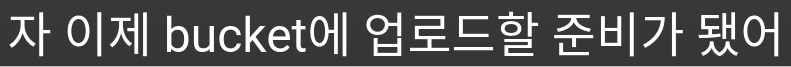

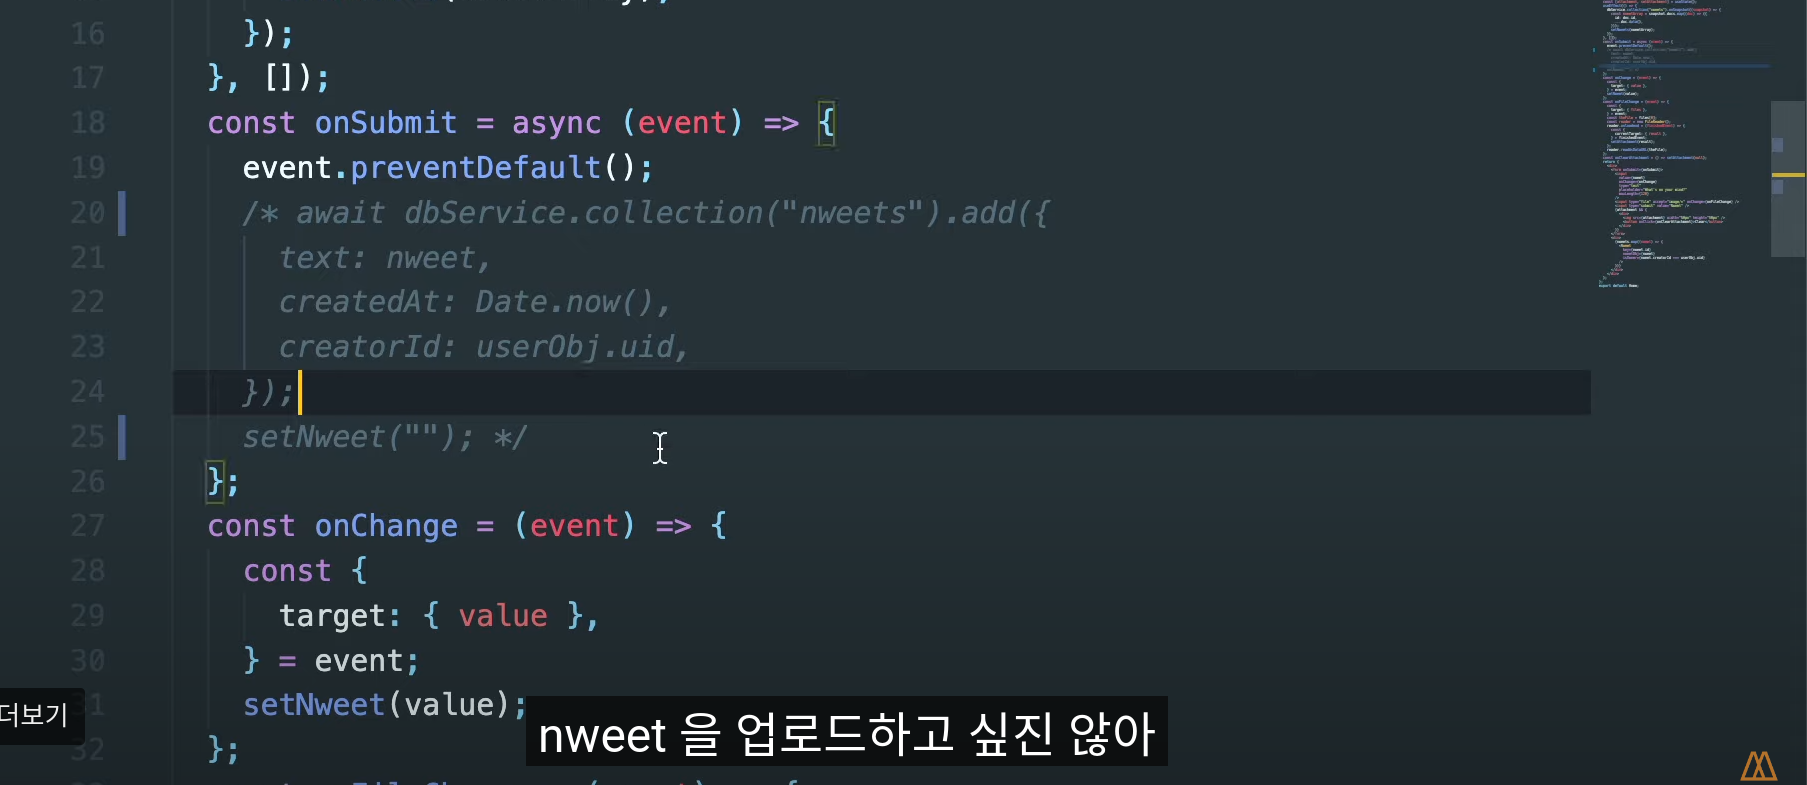

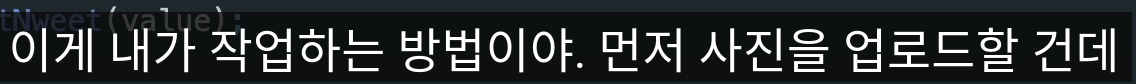

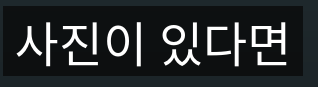

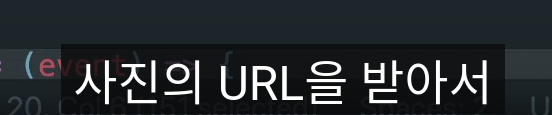

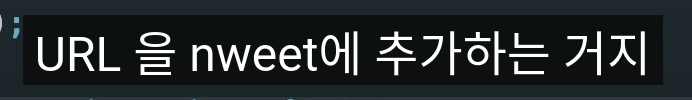

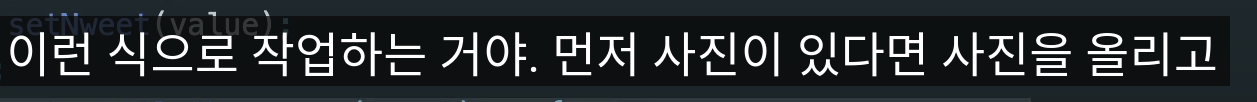

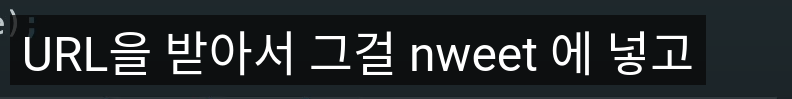

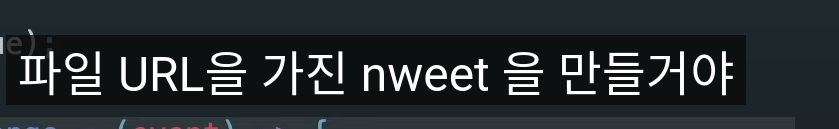

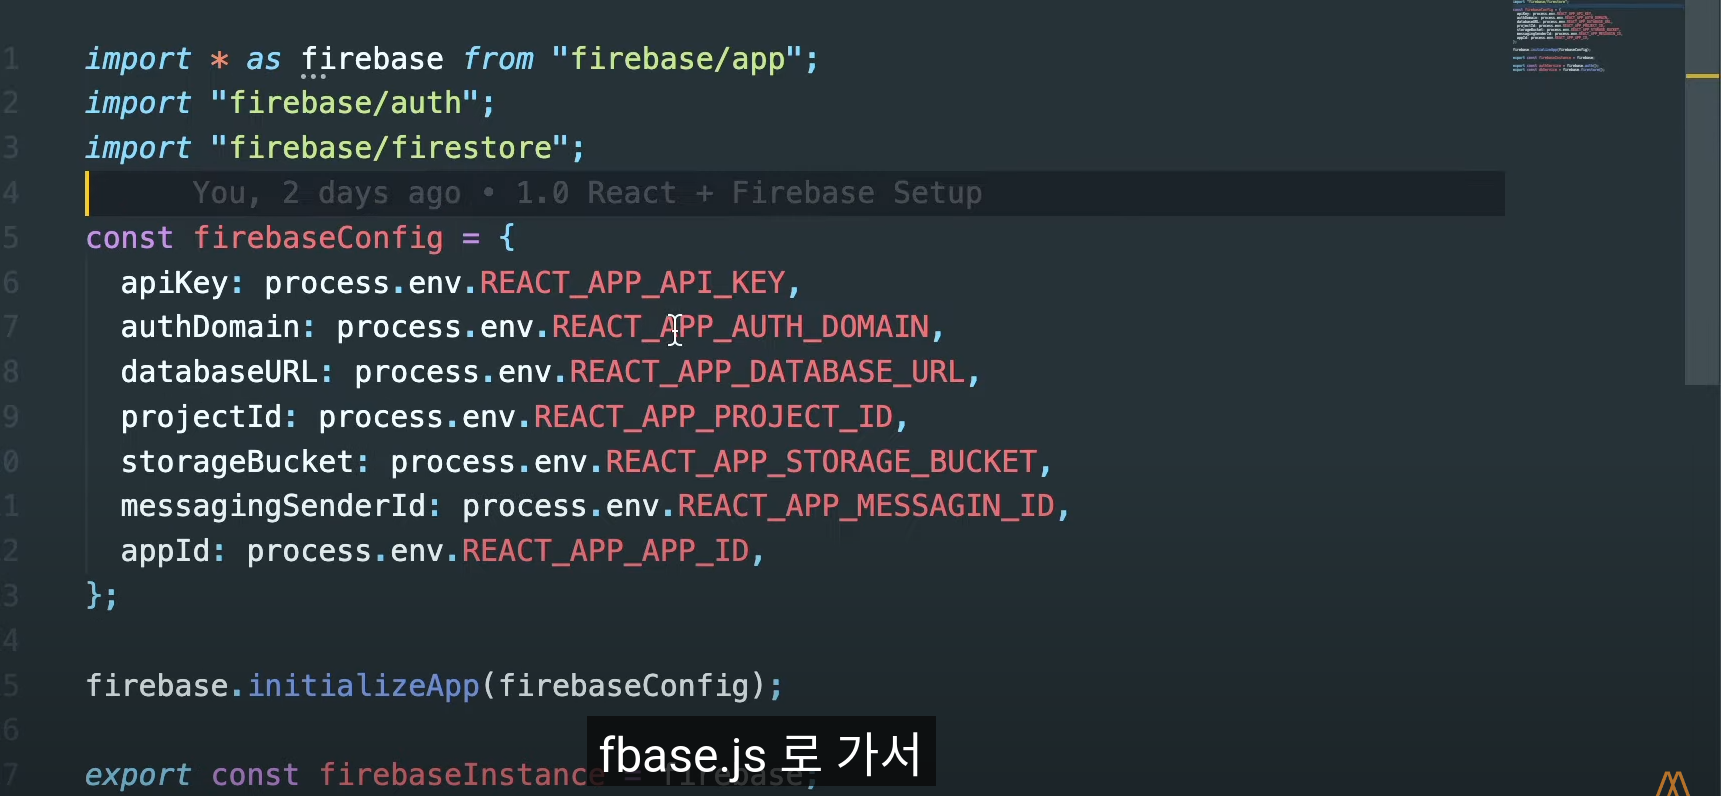

# fbase.js
```jsx
// ref
// https://firebase.google.com/docs/auth/web/start?hl=ko&authuser=1
import { initializeApp } from "firebase/app";
import { getAuth } from "firebase/auth";
// ref getFirestore https://firebase.google.com/docs/firestore/quickstart?hl=ko#web-version-9
import { getFirestore } from "firebase/firestore";
// ref https://firebase.google.com/docs/storage/web/upload-files
import { getStorage } from "firebase/storage";

// Your web app's Firebase configuration
const firebaseConfig = {
  apiKey: process.env.REACT_APP_API_KEY,
  authDomain: process.env.REACT_APP_AUTH_DOMAIN,
  projectId: process.env.REACT_APP_PROJECT_ID,
  storageBucket: process.env.REACT_APP_STORAGE_BUCKET,
  messagingSenderId: process.env.REACT_APP_MESSAGING_SENDER_ID,
  appId: process.env.REACT_APP_APP_ID,
};

// Initialize Firebase
const app = initializeApp(firebaseConfig);

export const authService = getAuth(app);

// Initialize Cloud Firestore and get a reference to the service
export const dbService = getFirestore(app);

// Initialize Cloud Storage and get a reference to the service
export const storageService = getStorage(app);

```

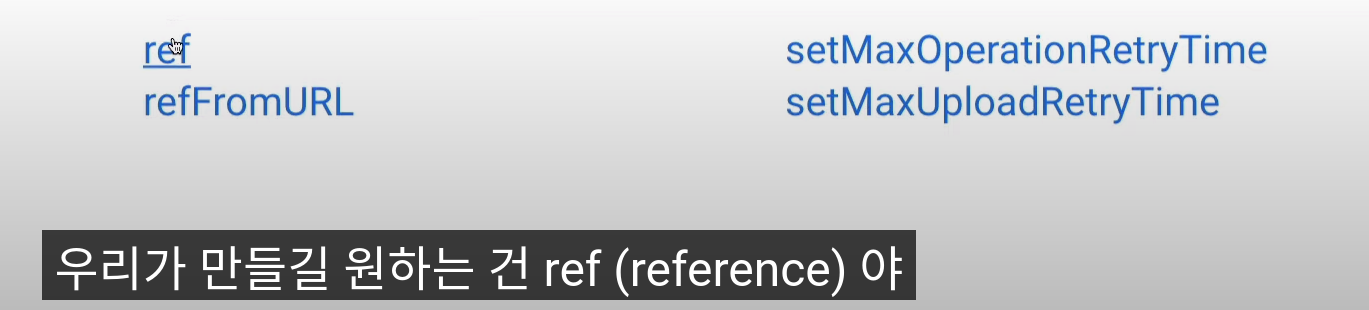

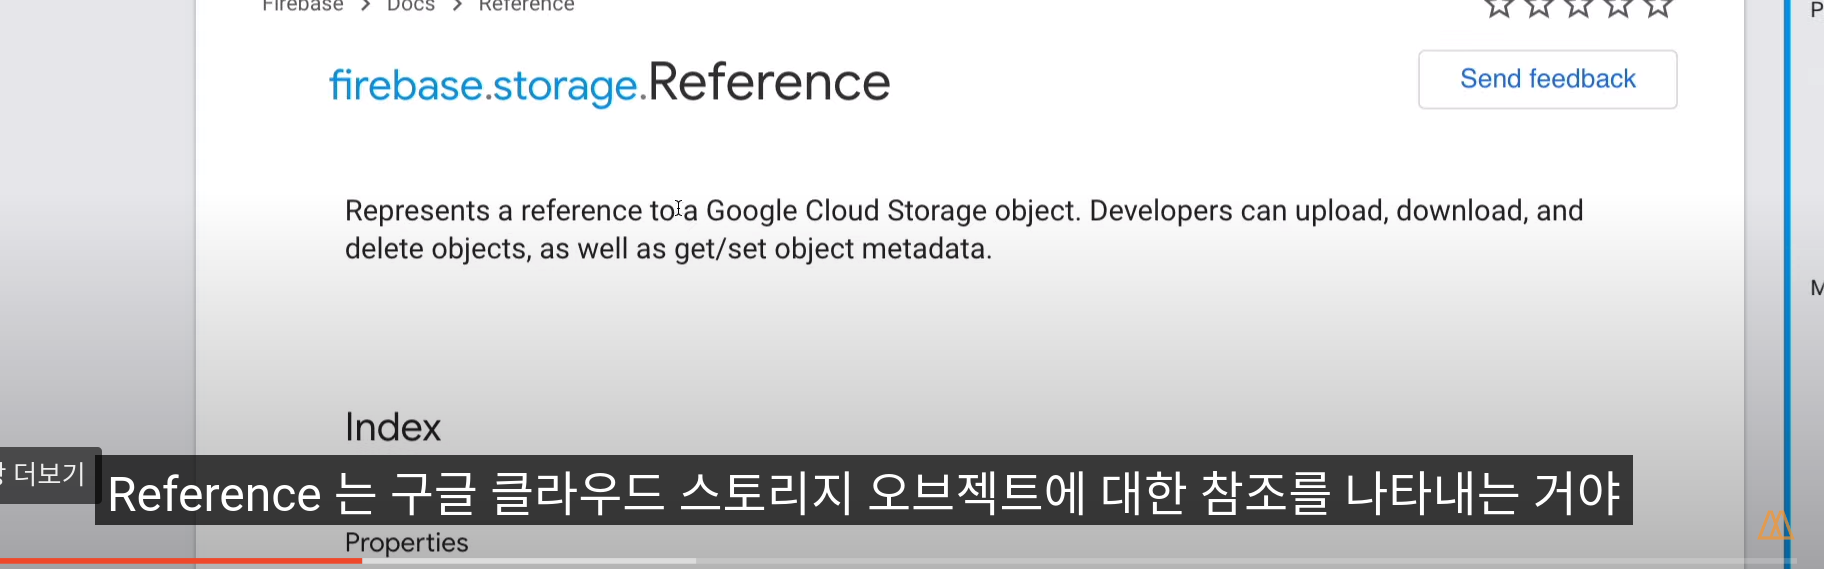

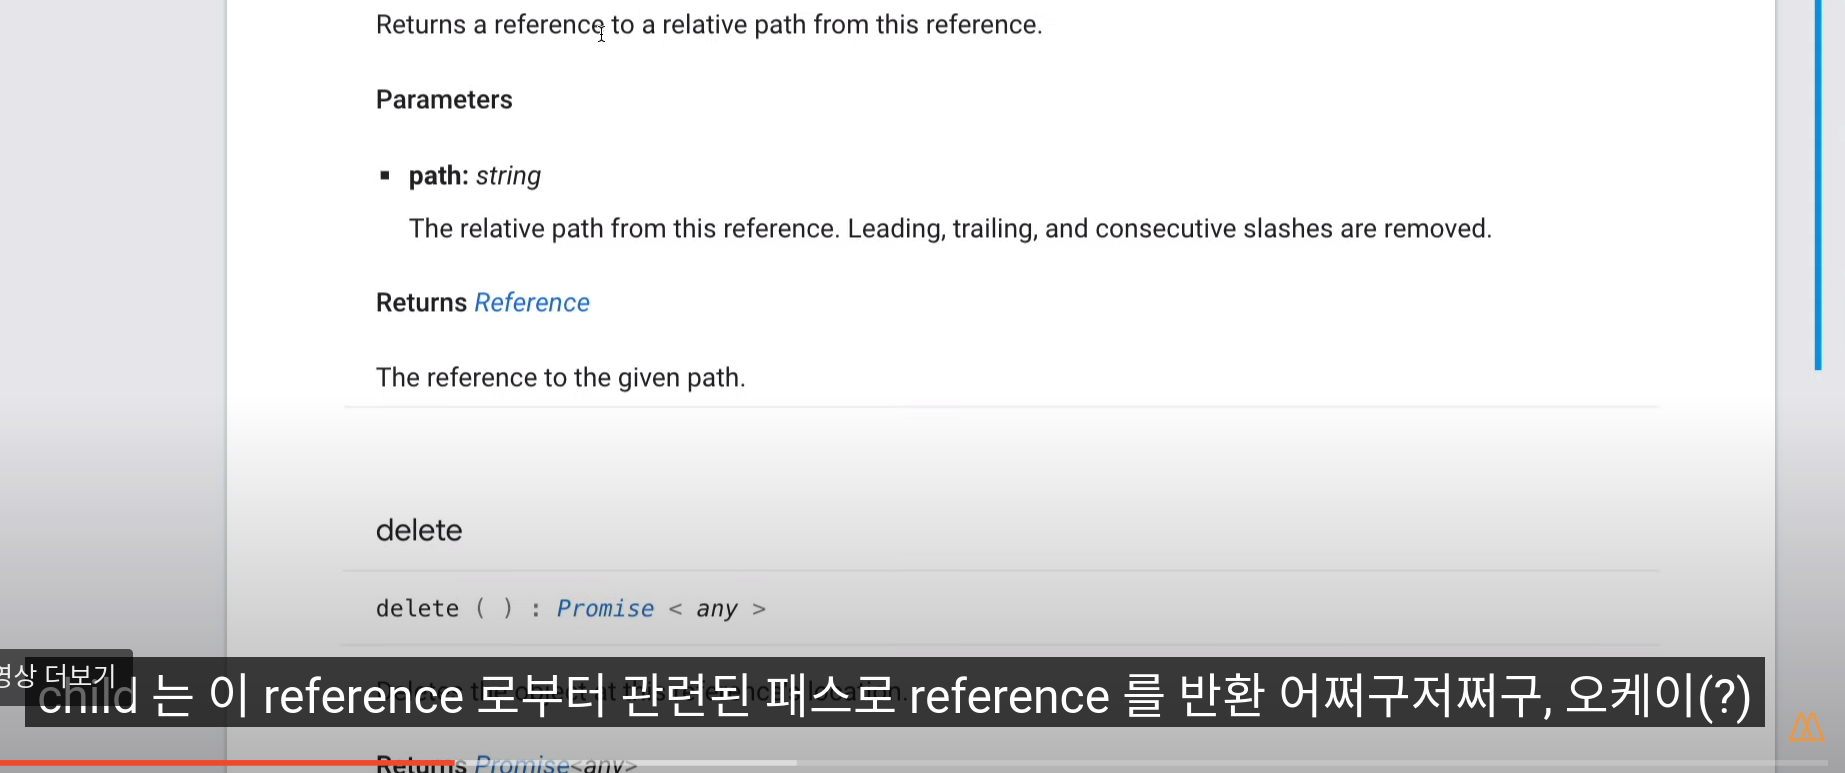

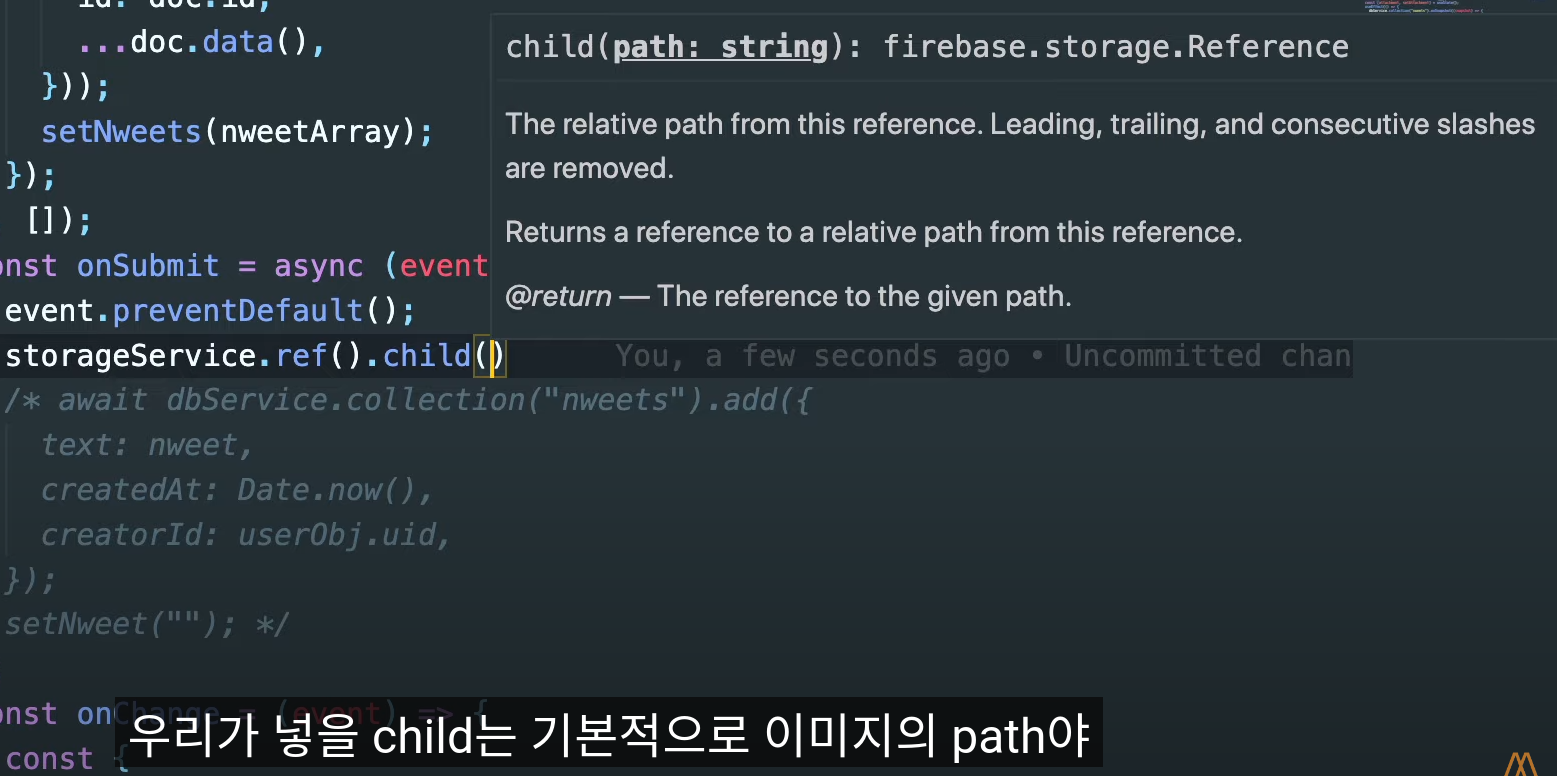

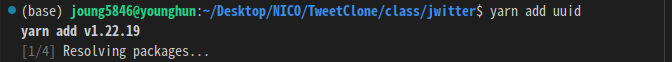

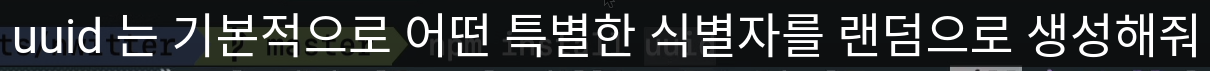

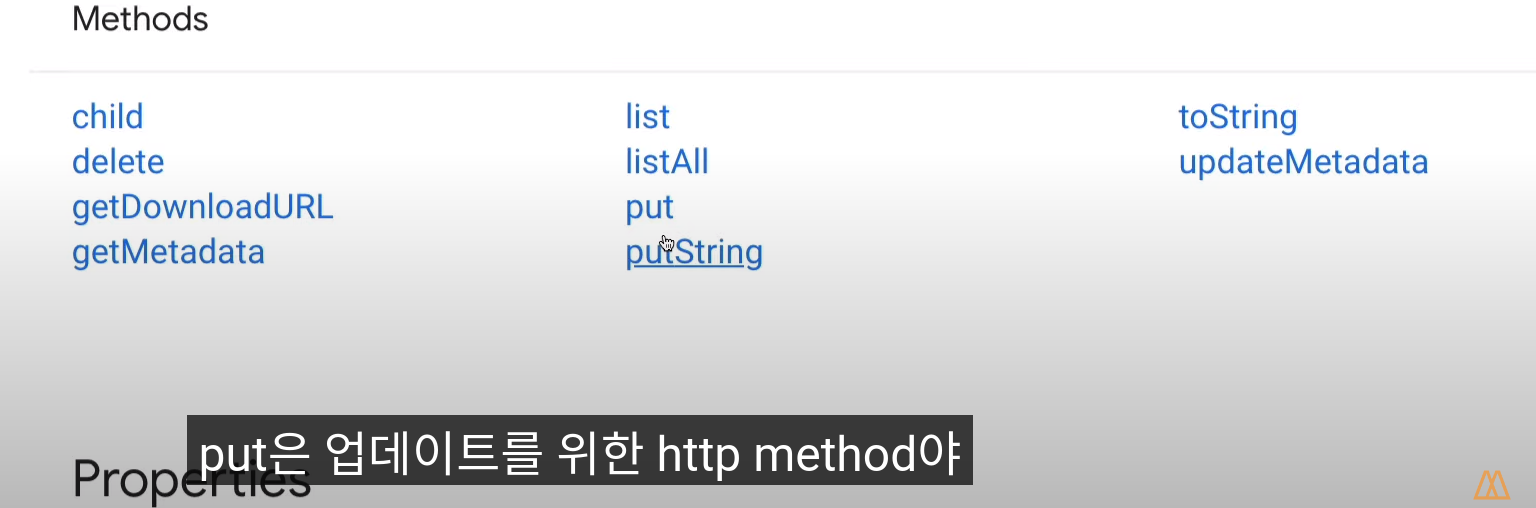


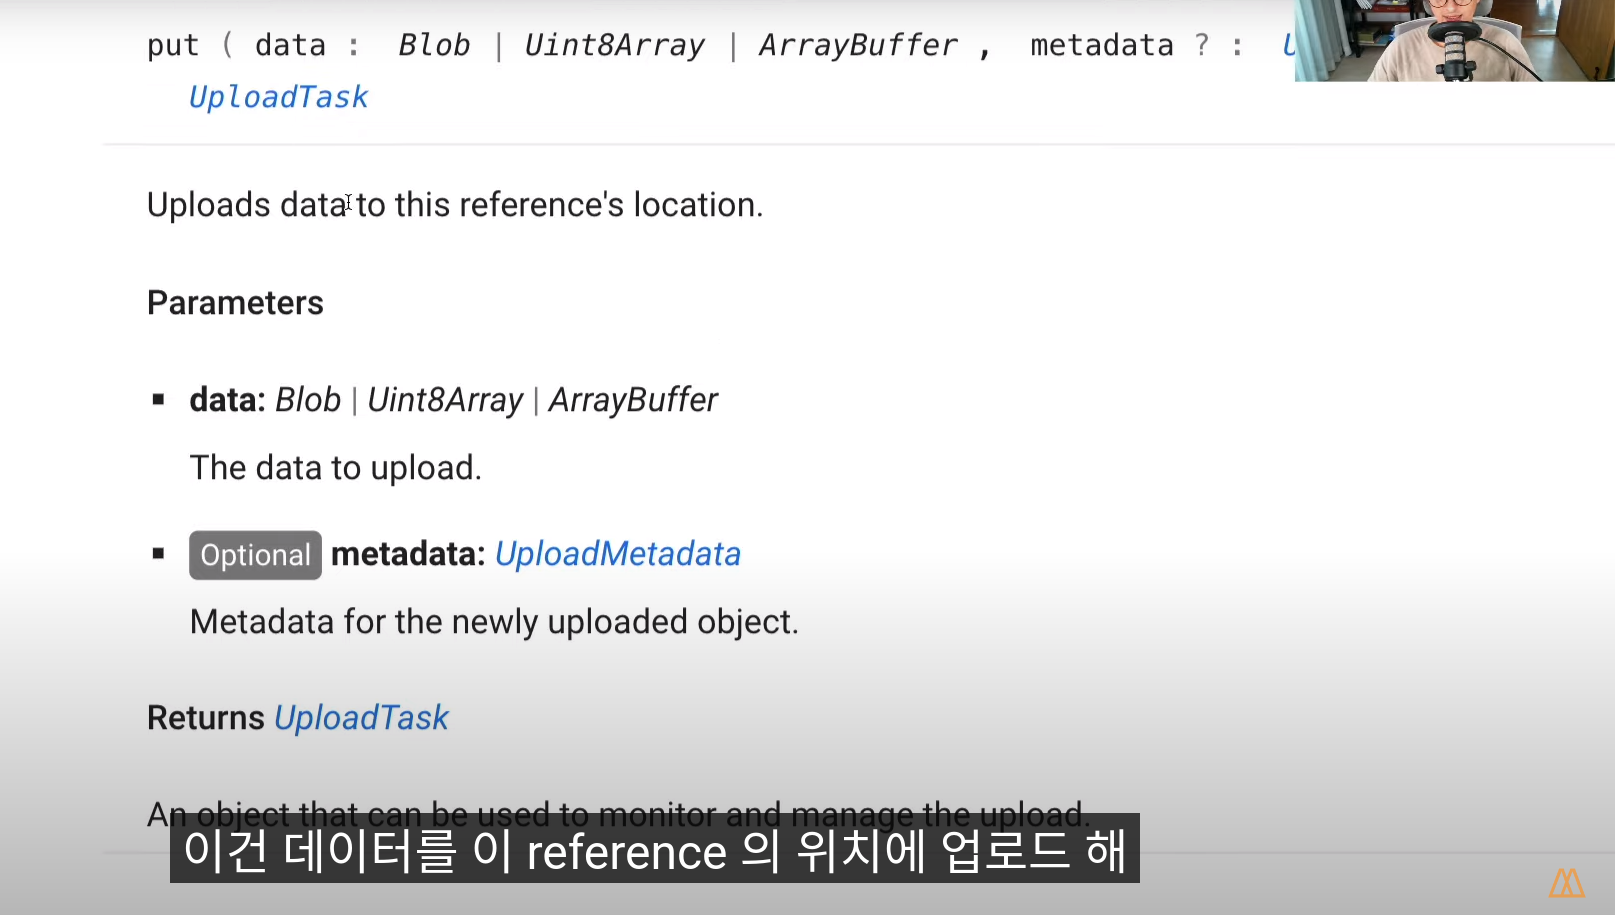

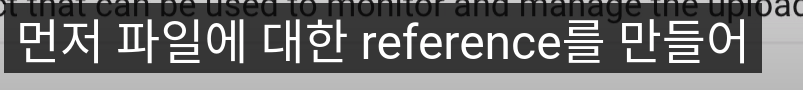

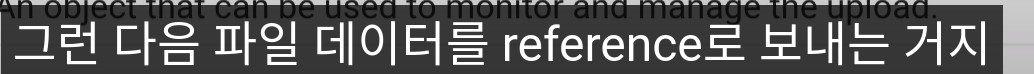

# Home.js
```jsx
import { useState, useEffect } from "react";
// firestore - https://firebase.google.com/docs/firestore/quickstart?hl=ko#web-version-9
import {
  collection,
  addDoc,
  // getDocs,
  query,
  orderBy,
  onSnapshot,
} from "firebase/firestore";
// storage - https://firebase.google.com/docs/storage/web/upload-files
import { ref, uploadString } from "firebase/storage";

// yarn add uuid - 특별식별자를 랜덤으로 생성
import { v4 as uuidv4 } from "uuid";

import { dbService, storageService } from "fbase";
import Jweet from "components/Jweet";

function Home({ userObj }) {
  const [jweet, setJweet] = useState("");
  const [jweets, setJweets] = useState([]);
  // 이미지url를 담을 state
  const [attachment, setAttachment] = useState();

  useEffect(() => {
    // 실시간으로 데이터를 데이터베이스에서 가져오기
    const q = query(
      collection(dbService, "jweets"),
      // where('text', '==', 'hehe') // where뿐만아니라 각종 조건 이 영역에 때려부우면 됨
      orderBy("createdAt", "desc")
    );
    const unsubscribe = onSnapshot(q, (querySnapshot) => {
      const newArray = querySnapshot.docs.map((doc) => {
        return {
          id: doc.id,
          ...doc.data(),
        };
      });
      setJweets(newArray);
    });

    return () => {
      unsubscribe();
    };
  }, []);

  const onSubmit = async (event) => {
    event.preventDefault();
    const fileRef = ref(storageService, `${userObj.uid}/${uuidv4()}`);
    const response = await uploadString(fileRef, attachment, "data_url");
    console.log(response);
    // // 저장
    // try {
    //   await addDoc(collection(dbService, "jweets"), {
    //     text: jweet,
    //     createdAt: Date.now(),
    //     creatorId: userObj.uid,
    //   });
    // } catch (error) {
    //   console.log(error.message);
    // }
    // setJweet("");
  };

  const onChange = (event) => {
    const {
      target: { value },
    } = event;
    setJweet(value);
  };

  const onFileChange = (event) => {
    // console.log(event.target.files);
    const {
      target: { files },
    } = event;

    const theFile = files[0];
    // FileReader API -> 검색
    const reader = new FileReader();

    // 파일리더에 after이벤트를 붙임
    reader.onloadend = (finishedEvent) => {
      const {
        currentTarget: { result },
      } = finishedEvent;
      setAttachment(result);
    };
    // 파일을 읽음
    reader.readAsDataURL(theFile);
  };
  const onClickClearAttachment = () => setAttachment(null);
  return (
    <>
      <form onSubmit={onSubmit}>
        <input
          type="text"
          placeholder="What's on your mind?"
          maxLength={120}
          onChange={onChange}
          value={jweet}
        />
        <input type="file" accept="image/*" onChange={onFileChange} />
        <input type="submit" value="Jweet" />
        {attachment && (
          <>
            <img src={attachment} width="50px" height="50px" />
            <button onClick={onClickClearAttachment}>Cancel</button>
          </>
        )}
      </form>
      <div>
        {jweets.map((jweet) => {
          return (
            <Jweet
              key={jweet.id}
              jweetObj={jweet}
              isOwner={jweet.creatorId === userObj.uid}
            />
          );
        })}
      </div>
    </>
  );
}

export default Home;

```